In [1]:
#전처리에 필요한 모듈
import pandas as pd
import numpy as np

In [19]:
#데이터셋 로드
train_data = pd.read_csv('train_df.csv',sep='w',index_col=0)
test_data = pd.read_csv('test_df.csv',sep='w',index_col=0)

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581 entries, 1893 to 448
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rating   1581 non-null   int64 
 1   label    1581 non-null   int64 
 2   reviews  1581 non-null   object
dtypes: int64(2), object(1)
memory usage: 49.4+ KB


In [23]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 1135 to 213
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rating   396 non-null    int64 
 1   label    396 non-null    int64 
 2   reviews  396 non-null    object
dtypes: int64(2), object(1)
memory usage: 12.4+ KB


In [24]:
#형태소 분석기로 어간 추출 및 불용어 제거 
#한국어 텍스트 전처리할때는 konlpy를 사용
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [28]:
stop_words = pd.read_csv('https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt')
okt=Okt()
clean_train_review=[]

def preprocessing(review):
    word_review = okt.morphs(review,stem=True)    #형태소로 나눔
    word_review = [token for token in word_review if not token in stop_words]  #불용어 제거
    word_review = [x for x in word_review if len(x) > 1] # 1글자 단어를 제외하고 추출
    return word_review

In [29]:
for review in train_data['reviews']:
    clean_train_review.append(preprocessing(review))
    
clean_train_review[:1]

[['에어팟',
  '세대',
  '이다',
  '에어팟',
  '프로',
  '갈아타다',
  '주변',
  '에서',
  '노이즈',
  '슬링',
  '신세계',
  '라는',
  '바로',
  '지르다',
  '버리다',
  '스마트',
  '으로',
  '퇴근길',
  '가깝다',
  '에서',
  '픽업',
  '하다',
  '있다',
  '자주',
  '이용',
  '하다',
  '같다']]

In [31]:
#테스트셋도 동일하게 추출
clean_test_review=[]
for review in test_data['reviews']:
    clean_test_review.append(preprocessing(review))

clean_test_review[:1]

[['최고',
  '에요',
  '나오다',
  '누가',
  '이어폰',
  '만원',
  '주다',
  '재정',
  '신인',
  '늘다',
  '지금',
  '이십만원',
  '주다',
  '이어폰',
  '사다',
  '사다',
  '홍보',
  '대사',
  '노이즈',
  '슬링',
  '정말',
  '신세계',
  '무조건',
  '사다',
  '야하다',
  '신기하다',
  '세상',
  '알리다',
  '증말',
  '좋다']]

In [32]:
total_data_text = clean_train_review + clean_test_review

In [34]:
num_tokens = [len(token) for token in total_data_text]
num_tokens = np.array(num_tokens)

In [35]:
print('문장길이 평균:',np.mean(num_tokens))
print('문장길이 최대:',np.max(num_tokens))
print('문장길이 표준편차:',np.std(num_tokens))

문장길이 평균: 45.375316135558926
문장길이 최대: 426
문장길이 표준편차: 29.840509408078887


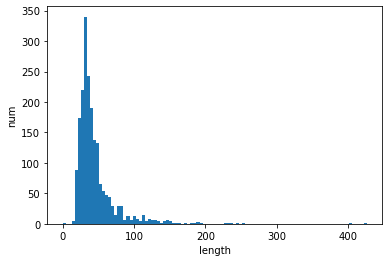

In [39]:
import matplotlib.pyplot as plt

plt.hist([len(review) for review in total_data_text], bins=100)
plt.xlabel('length')
plt.ylabel('num')
plt.show()

In [ ]:
#그래프로 보았을때 100정도가 적당해보인다

In [43]:
#최대 길이를 (평균 + 2*표준편차)로 하여 확인
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  105
전체 문장의 95.45%가 maxlen 설정값 이내에 포함됩니다. 


In [45]:
# 데이터 백터화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index
MAX_SEQUENCE_LENGTH = maxlen #문장 최대 길이

#학습 데이터 패딩처리
train_inputs = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')

#학습 데이터 라벨 벡터화
train_labels = np.array(train_data['label'])

#평가 데이터 패딩처리
test_inputs = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')
#평가 데이터 라벨 벡터화
test_labels = np.array(test_data['label'])

In [47]:
train_inputs.shape, train_labels.shape

((1581, 105), (1581,))

In [60]:
import json

In [61]:
#파일로 넘파이 파일로 저장
DATA_PATH = 'CLEAN_DATA/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_config.json'

data_configs={}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

#전처리한 데이터들 파일로저장
import os

if not os.path.exists(DATA_PATH):
  os.makedirs(DATA_PATH)

#전처리 학습데이터 넘파이로 저장
np.save(open(DATA_PATH+TRAIN_INPUT_DATA,'wb'),train_inputs)
np.save(open(DATA_PATH+TRAIN_LABEL_DATA,'wb'),train_labels)
#전처리 테스트데이터 넘파이로 저장
np.save(open(DATA_PATH+TEST_INPUT_DATA,'wb'),test_inputs)
np.save(open(DATA_PATH+TEST_LABEL_DATA,'wb'),test_labels)

#데이터 사전 json으로 저장
json.dump(data_configs,open(DATA_PATH + DATA_CONFIGS,'w'),ensure_ascii=False)

In [77]:
#학습하기

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [92]:
vocab_size = len(word_vocab)+1
embedding_dim = 16

model = Sequential()
model.add(Embedding(vocab_size,embedding_dim, input_shape=(None,)))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))  #이진분류모델로 활성화함수 시그모이드사용
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          82448     
                                                                 
 gru_3 (GRU)                 (None, 128)               56064     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 138,641
Trainable params: 138,641
Non-trainable params: 0
_________________________________________________________________


In [93]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [94]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_inputs, train_labels, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
21/22 [===========================>..] - ETA: 0s - loss: 0.5180 - acc: 0.7984
Epoch 1: val_acc improved from -inf to 0.89274, saving model to best_model.h5
22/22 [==============================] - 4s 107ms/step - loss: 0.5182 - acc: 0.7983 - val_loss: 0.4018 - val_acc: 0.8927
Epoch 2/15
21/22 [===========================>..] - ETA: 0s - loss: 0.4687 - acc: 0.8278
Epoch 2: val_acc did not improve from 0.89274
22/22 [==============================] - 2s 80ms/step - loss: 0.4680 - acc: 0.8283 - val_loss: 0.3449 - val_acc: 0.8927
Epoch 3/15
21/22 [===========================>..] - ETA: 0s - loss: 0.4636 - acc: 0.8278
Epoch 3: val_acc did not improve from 0.89274
22/22 [==============================] - 2s 79ms/step - loss: 0.4627 - acc: 0.8283 - val_loss: 0.3905 - val_acc: 0.8927
Epoch 4/15
21/22 [===========================>..] - ETA: 0s - loss: 0.4648 - acc: 0.8286
Epoch 4: val_acc did not improve from 0.89274
22/22 [==============================] - 2s 79ms/step - loss: 0.465

In [91]:
#평가하기

model.load_weights('best_model.h5')
model.evaluate(test_inputs, test_labels)

13/13 [==============================] - 0s 22ms/step - loss: 0.5545 - acc: 0.8409


[0.554478645324707, 0.8409090638160706]

In [ ]:
#  84프로의 정확도를 보인다

In [63]:
#예측하기

import re

In [87]:
sentence = input('감성분석할 문장을 입력해 주세요.: ')
sentence = re.sub(r'[^가-힣 ]','', sentence)
stopwords = pd.read_csv('https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt')
sentence = okt.morphs(sentence, stem=True) # 토큰화
sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
vector  = tokenizer.texts_to_sequences(sentence)
pad_new = pad_sequences(vector, maxlen = 8) # 패딩

model.load_weights('best_model.h5')
predictions = model.predict(pad_new)
predictions = float(predictions.squeeze(-1)[1])

if(predictions > 0.5):
  print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(predictions * 100))
else:
  print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - predictions) * 100))

감성분석할 문장을 입력해 주세요.: 배송빠르고 좋아요
84.56% 확률로 긍정 리뷰입니다.

